In [1]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [5]:
%env SPOTIPY_CLIENT_ID = 3543bc68b7a64fa4896cb0c1d2499e33
%env SPOTIPY_CLIENT_SECRET = b711f5fe2e9a417c89247f7036c9c069

env: SPOTIPY_CLIENT_ID=3543bc68b7a64fa4896cb0c1d2499e33
env: SPOTIPY_CLIENT_SECRET=b711f5fe2e9a417c89247f7036c9c069


In [6]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from collections import Counter

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

In [7]:
#USEFUL FUNCTIONS

#results = sp.search(q='urbancoyotes', limit=20)
#for idx, track in enumerate(results['tracks']['items']):
   # print(idx, track['name'])
    
#import json
#playlist_id = 'spotify:user:spotifycharts:playlist:37i9dQZEVXbJiZcmkrIHGU'
#results = sp.playlist(playlist_id)
#print(json.dumps(results, indent=4))

#birdy = 'spotify:artist:2WX2uTcsvV5OnS0inACecP'
#results = spotify.artist_albums(birdy, album_type='album')
#albums = results['items']
#while results['next']:
#     results = spotify.next(results)
#     albums.extend(results['items'])

#for album in albums:
#     print(album['name'])

#artist = sp.artist(birdy)
#print(artist)

#print("")
#user = sp.user('kolsen118')
#print(user)

In [8]:
for term in ["Coronavirus"]:
    print(sp.search('q="{}"'.format(term), type='playlist')['playlists']['total'])

2358


In [9]:
#function that creates a list with the playlist name, total number of tracks
def batch_proccess(x,lista):
    for i in x['playlists']['items']:
        lista.append({"name" : i['name'], "total":i["tracks"]['total'], "uri":i["uri"]})

In [10]:
list_of_playlists = []
for term in ["Coronavirus"]:
    for i in range(0,2000,50):
        try:
            init_data = sp.search('q="{}"'.format(term), type='playlist', limit=50, offset=i)
            batch_proccess(init_data,list_of_playlists)
        except:
            print("Error")

In [11]:
playlists = pd.DataFrame(list_of_playlists).drop_duplicates().reset_index(drop=True)

In [12]:
playlists.to_csv("playlists.csv")

In [13]:

songs = []
for uri in playlists['uri']:
        length = sp.playlist_tracks(uri)['total']
        for i in range(0,length, 50):
            init_data = sp.playlist_tracks(uri, limit=50, offset=i)
            try:
                for k in init_data['items']:
                    songs.append(k['track']["uri"])
            except:
                pass

KeyboardInterrupt: 

In [14]:
len(songs)

2605

In [15]:
#dataset with individual track uri and count
df = pd.DataFrame.from_dict(Counter(songs), orient='index').reset_index().rename(columns={"index":"uri", 0:"count"})

In [16]:
df

,uri,count
0,spotify:track:4vfToX0AaZZJDotaS2SSj3,1
1,spotify:track:6U0FIYXCQ3TGrk4tFpLrEA,1
2,spotify:track:5JRMqkR82k2fdDEAim9SCN,1
3,spotify:track:2fLh3IR5LqcDGXx78Bl6TB,1
4,spotify:track:2acJbUC1QBeS4whMOoKiH3,1
...,...,...
2531,spotify:track:1s2B5cndbqK8rPJEIcKJRQ,1
2532,spotify:track:09S64DUkxIX9EwIaULu6yN,1
2533,spotify:track:75EveQXAVJzwuEO9gjfyGZ,1
2534,spotify:track:1RouRzlg8OKFeqc6LvdxmB,1


In [31]:
#creates a csv file
df.to_csv("song_list_unfiltered.csv")

In [32]:
#creates a dataframe describing basic stats for number of songs in playlists
df[(df['count']>0) & (df['count']<900)].describe()

,count
count,2536.000000
mean,1.027208
std,0.220384
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,5.000000


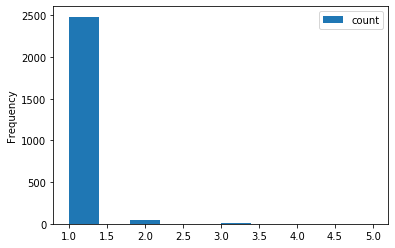

In [33]:
#creates a histogram that plots the count of each track
#count on x-axis, number of songs with that count on y-axis
%matplotlib inline
df[(df['count']>0) & (df['count']<900)].plot.hist()

In [34]:
#cuts off any tracks that appear less than once
df_f = df[df['count']>1]

In [35]:
#data enrich, filters important variables
def data_enrich(x):
    data = sp.track(x['uri'])
    name = data['name']
    pop = data['popularity']
    date = data['album']['release_date']
    features = sp.audio_features(x['uri'])
    return {**x, "name" : name, 'release_date': date, "popularity" : pop,
            'explicit' : data['explicit'] , **features[0] }

In [36]:
final = df_f.apply(lambda x: data_enrich(x), axis=1, result_type='expand')

In [37]:
final

,uri,count,name,release_date,popularity,explicit,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
15,spotify:track:6ap9lSRJ0iLriGLqoJ44cq,2,CITY OF ANGELS,2019-11-22,90,False,0.686,0.541,0,-4.993,...,0.000000,0.0675,0.7240,120.084,audio_features,6ap9lSRJ0iLriGLqoJ44cq,https://api.spotify.com/v1/tracks/6ap9lSRJ0iLr...,https://api.spotify.com/v1/audio-analysis/6ap9...,112493,4
24,spotify:track:3Dv1eDb0MEgF93GpLXlucZ,2,Say So,2019-11-07,97,True,0.787,0.673,11,-4.577,...,0.000004,0.0904,0.7860,110.962,audio_features,3Dv1eDb0MEgF93GpLXlucZ,https://api.spotify.com/v1/tracks/3Dv1eDb0MEgF...,https://api.spotify.com/v1/audio-analysis/3Dv1...,237893,4
28,spotify:track:4nK5YrxbMGZstTLbvj6Gxw,2,Supalonely,2019-11-15,95,True,0.863,0.631,7,-4.689,...,0.000030,0.1230,0.8170,128.977,audio_features,4nK5YrxbMGZstTLbvj6Gxw,https://api.spotify.com/v1/tracks/4nK5YrxbMGZs...,https://api.spotify.com/v1/audio-analysis/4nK5...,223480,4
30,spotify:track:1rgnBhdG2JDFTbYkYRZAku,2,Dance Monkey,2019-05-10,75,False,0.825,0.593,6,-6.401,...,0.000161,0.1700,0.5400,98.078,audio_features,1rgnBhdG2JDFTbYkYRZAku,https://api.spotify.com/v1/tracks/1rgnBhdG2JDF...,https://api.spotify.com/v1/audio-analysis/1rgn...,209755,4
42,spotify:track:21jGcNKet2qwijlDFuPiPb,2,Circles,2019-09-06,95,False,0.695,0.762,0,-3.497,...,0.002440,0.0863,0.5530,120.042,audio_features,21jGcNKet2qwijlDFuPiPb,https://api.spotify.com/v1/tracks/21jGcNKet2qw...,https://api.spotify.com/v1/audio-analysis/21jG...,215280,4
60,spotify:track:1B75hgRqe7A4fwee3g3Wmu,2,U Can't Touch This,1990-02-20,74,False,0.867,0.517,11,-13.222,...,0.000339,0.0864,0.8660,133.148,audio_features,1B75hgRqe7A4fwee3g3Wmu,https://api.spotify.com/v1/tracks/1B75hgRqe7A4...,https://api.spotify.com/v1/audio-analysis/1B75...,257360,4
65,spotify:track:2xLMifQCjDGFmkHkpNLD9h,2,SICKO MODE,2018-08-03,92,True,0.834,0.730,8,-3.714,...,0.000000,0.1240,0.4460,155.008,audio_features,2xLMifQCjDGFmkHkpNLD9h,https://api.spotify.com/v1/tracks/2xLMifQCjDGF...,https://api.spotify.com/v1/audio-analysis/2xLM...,312820,4
78,spotify:track:60a0Rd6pjrkxjPbaKzXjfq,2,In the End,2000-10-24,84,False,0.556,0.864,3,-5.870,...,0.000000,0.2090,0.4000,105.143,audio_features,60a0Rd6pjrkxjPbaKzXjfq,https://api.spotify.com/v1/tracks/60a0Rd6pjrkx...,https://api.spotify.com/v1/audio-analysis/60a0...,216880,4
102,spotify:track:5UgT7w6zVZjP3oyawMzbiK,2,The End,1967-01-04,64,True,0.347,0.302,0,-12.104,...,0.000092,0.1400,0.0332,105.702,audio_features,5UgT7w6zVZjP3oyawMzbiK,https://api.spotify.com/v1/tracks/5UgT7w6zVZjP...,https://api.spotify.com/v1/audio-analysis/5UgT...,703373,4
312,spotify:track:0QnONzv3TvHAWk294h6DaQ,2,Last Kiss,1999,71,False,0.622,0.692,7,-6.970,...,0.000158,0.1930,0.7740,112.053,audio_features,0QnONzv3TvHAWk294h6DaQ,https://api.spotify.com/v1/tracks/0QnONzv3TvHA...,https://api.spotify.com/v1/audio-analysis/0QnO...,195467,4


In [26]:
#makes a csv with the final dataset
final.to_csv("song_list.csv",)